# problem statement

https://www.kaggle.com/c/techsoc-roadmaps-analytics-22/

In this competition, you are tasked with predicting the housing prices using machine learning techniques!

There are two files train.csv and test.csv. The train.csv contains 19 columns and the column to be predicted is the price. The test.csv contains 18 columns - (everything except the column price).

The following is the description of each column

| Column Name | Description | Comments |
|-------------|-------------|----------|
| Id | Notation for a house |  |
| Date | Date house was sold |  |
| Price | Price is the prediction target |  |
| Bedrooms | Number of Bedrooms/House |  |
| Sqft_living | Area of the home |  |
| Sqft_lot | Area footage of the lot |  |
| Floors | Total floors (levels) in house |  |
| Waterfront | House which has a view to a waterfront | 0 or 1 |
| Condition | How good the condition is (Overall) |  |
| Grade | The overall grade given to the housing unit |  |
| Sqft_above | Area of house apart from the basement |  |
| Sqft_basement | Area of the basement |  |
| Yr_built | Built Year |  |
| Yr_renovated | The year when the house was renovated |  |
| Zipcode | zip |  |
| Lat Latitude | coordinate |  |
| Long Longitude | coordinate |  |
| Sqft_living15 | Living room area in 2015 | implies some renovations |
| Sqft_lot15 | lot size area in 2015 | implies some renovations |

20 submissions per day

# libraries

import a bunch of libraries, these have all the things we need

In [362]:
# remove pandas' annoying warning about Int64Index
import warnings
warnings.filterwarnings('ignore')

# basic stuff:
import pandas as pd
import numpy as np


# visualization:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# from pandas_profiling import ProfileReport
# not importing that one because it doesn't work for whatever reason


# finding correlations:
from scipy import stats


# model building:
from sklearn.model_selection import train_test_split


# regressors:
# logistic regression
# tries to fit a line
from sklearn.linear_model import LinearRegression

# decision tree
# https://www.youtube.com/watch?v=7VeUPuFGJHk
from sklearn.tree import DecisionTreeRegressor

# bagging
from sklearn.ensemble import BaggingRegressor

# random forest
# https://www.youtube.com/playlist?list=PLblh5JKOoLUIE96dI3U7oxHaCAbZgfhHk
from sklearn.ensemble import RandomForestRegressor

# gradient boosting
# https://www.youtube.com/playlist?list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor


# parameter tuning, cross validation:
from sklearn.model_selection import GridSearchCV, KFold, cross_validate


# timing
import datetime

# helper functions

this one below is the one we use to fix the units in columns like `sqft_living`, `sqft_lot`, etc.

In [41]:
def fix_unit(col_name, df):
    series = df[col_name].str.extract(r'(?P<value>[0-9.]+)\s*(?P<unit>.+)')

    def sqft_fix(s):
        val = float(s['value'])
        if s['unit'] == 'sqm':
            val = val * 10.7639
        return val
    
    series = series.apply(sqft_fix, axis=1)
    series.name = col_name
    
    df = df.drop([col_name], axis=1)
    return df.join(series)

# import data

import the training csv file, take only 20% of the data since it's huge, then display it

In [277]:
full_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
df = full_df.sample(frac=0.1, random_state=1)

df

,id,date,price,bedrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1409,6860873,7/26/2014,686000.0,4BHK,2130 sqft,10650 sqft,2.0,0,good,average,2130,0,1977,1869,98006,47.5567,-122.159,3380 sqft,10050 sqft
12506,5950011,7/16/2014,595000.0,4BHK,1350 sqft,8113 sqft,1.0,0,good,average,1350,0,1959,1869,98004,47.5807,-122.196,1930 sqft,8113 sqft
15008,3500386,7/26/2014,350000.0,3BHK,1210 sqft,941 sqft,2.0,0,average,average,1000,210,2002,1869,98133,47.7114,-122.356,1650 sqft,1493 sqft
2674,1150871,12/5/2014,115000.0,2BHK,1000 sqft,16524 sqft,1.0,0,average,poor,1000,0,1913,1869,98001,47.2841,-122.255,1350 sqft,10208 sqft
4314,7625070,26/8/2014,762500.0,4BHK,292.635 sqm,555.4490999999999 sqm,2.0,0,average,good,3150,0,2005,1869,98052,47.7082,-122.101,292.635 sqm,612.6754999999999 sqm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,4340752,12/16/2014,434000.0,3BHK,1750 sqft,9353 sqft,1.0,0,average,average,1210,540,1987,1869,98034,47.7305,-122.225,1930 sqft,8545 sqft
14314,3000245,14/1/2015,300000.0,4BHK,1890 sqft,9205 sqft,1.0,0,average,average,1260,630,1964,1869,98133,47.7740,-122.348,1430 sqft,6775 sqft
613,4930128,10/16/2014,493000.0,4BHK,1910 sqft,2874 sqft,1.0,0,average,average,1060,850,1910,1869,98122,47.6101,-122.295,1520 sqft,2874 sqft
9323,22000493,3/11/2015,2200000.0,5BHK,5840 sqft,17168 sqft,2.0,0,average,best,4570,1270,2006,1869,98029,47.5457,-121.991,4850 sqft,15017 sqft


# exploring data

drop any duplicates we may have (we don't have any so this doesn't do anything)

In [ ]:
df = df.drop_duplicates()
df

view the first 20 rows in our dataset, to see what kind of basic cleanup we need to do

In [ ]:
df.head(20)

`sqft` and `sqm` are mixed in some columns, so we need to convert them

In [ ]:
df.info()

so we need to fix `date`, `bedrooms`, `sqft_living`, `sqft_lot`, `condition`, `grade`, `sqft_living15`, `sqft_lot15`

## fix numbers

the below code just fixes the integers represented as strings

In [49]:
for col in ['bedrooms', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']:
    df = fix_unit(col, df)

### date

we're saving this as a date object so that we can apply some extra preprocessing later

In [50]:
date = pd.to_datetime(df['date'], infer_datetime_format=True)
date

1409    2014-07-26
12506   2014-07-16
15008   2014-07-26
2674    2014-12-05
4314    2014-08-26
           ...    
4414    2014-12-16
14314   2015-01-14
613     2014-10-16
9323    2015-03-11
7969    2015-02-24
Name: date, Length: 1721, dtype: datetime64[ns]

In [51]:
df = df.drop(['date'], axis=1)
df = df.join(date)
df

,id,price,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,bedrooms,sqft_living,sqft_living15,sqft_lot,sqft_lot15,date
1409,6860873,686000.0,2.0,0,good,average,2130,0,1977,1869,98006,47.5567,-122.159,4.0,2130.000000,3380.000000,10650.000000,10050.000000,2014-07-26
12506,5950011,595000.0,1.0,0,good,average,1350,0,1959,1869,98004,47.5807,-122.196,4.0,1350.000000,1930.000000,8113.000000,8113.000000,2014-07-16
15008,3500386,350000.0,2.0,0,average,average,1000,210,2002,1869,98133,47.7114,-122.356,3.0,1210.000000,1650.000000,941.000000,1493.000000,2014-07-26
2674,1150871,115000.0,1.0,0,average,poor,1000,0,1913,1869,98001,47.2841,-122.255,2.0,1000.000000,1350.000000,16524.000000,10208.000000,2014-12-05
4314,7625070,762500.0,2.0,0,average,good,3150,0,2005,1869,98052,47.7082,-122.101,4.0,3149.893876,3149.893876,5978.798567,6594.777814,2014-08-26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,4340752,434000.0,1.0,0,average,average,1210,540,1987,1869,98034,47.7305,-122.225,3.0,1750.000000,1930.000000,9353.000000,8545.000000,2014-12-16
14314,3000245,300000.0,1.0,0,average,average,1260,630,1964,1869,98133,47.7740,-122.348,4.0,1890.000000,1430.000000,9205.000000,6775.000000,2015-01-14
613,4930128,493000.0,1.0,0,average,average,1060,850,1910,1869,98122,47.6101,-122.295,4.0,1910.000000,1520.000000,2874.000000,2874.000000,2014-10-16
9323,22000493,2200000.0,2.0,0,average,best,4570,1270,2006,1869,98029,47.5457,-121.991,5.0,5840.000000,4850.000000,17168.000000,15017.000000,2015-03-11


## label encoding

list the labels we have to encode

In [52]:
objList = df.select_dtypes(include="object").columns

for obj in objList:
    print(obj)
    print(df[obj].value_counts())
    print("-------\n")

condition
average      1130
good          447
very good     129
poor           12
very poor       3
Name: condition, dtype: int64
-------

grade
average    1365
good        322
poor         26
best          8
Name: grade, dtype: int64
-------



doing manual replacement so it's easier to look at graphs (also CatBoost recommends against OneHot)

In [53]:
replacement = {
    "condition": {
        "very poor": 1,
        "poor": 2,
        "average": 3,
        "good": 4,
        "very good": 5
    },
    
    "grade": {
        "poor": 1,
        "average": 2,
        "good": 3,
        "best": 4
    }
}

df = df.replace(replacement)
df.head()

,id,price,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,bedrooms,sqft_living,sqft_living15,sqft_lot,sqft_lot15,date
1409,6860873,686000.0,2.0,0,4,2,2130,0,1977,1869,98006,47.5567,-122.159,4.0,2130.000000,3380.000000,10650.000000,10050.000000,2014-07-26
12506,5950011,595000.0,1.0,0,4,2,1350,0,1959,1869,98004,47.5807,-122.196,4.0,1350.000000,1930.000000,8113.000000,8113.000000,2014-07-16
15008,3500386,350000.0,2.0,0,3,2,1000,210,2002,1869,98133,47.7114,-122.356,3.0,1210.000000,1650.000000,941.000000,1493.000000,2014-07-26
2674,1150871,115000.0,1.0,0,3,1,1000,0,1913,1869,98001,47.2841,-122.255,2.0,1000.000000,1350.000000,16524.000000,10208.000000,2014-12-05
4314,7625070,762500.0,2.0,0,3,3,3150,0,2005,1869,98052,47.7082,-122.101,4.0,3149.893876,3149.893876,5978.798567,6594.777814,2014-08-26


make sure we're done with our replacements

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1721 entries, 1409 to 7969
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             1721 non-null   int64         
 1   price          1721 non-null   float64       
 2   floors         1721 non-null   float64       
 3   waterfront     1721 non-null   int64         
 4   condition      1721 non-null   int64         
 5   grade          1721 non-null   int64         
 6   sqft_above     1721 non-null   int64         
 7   sqft_basement  1721 non-null   int64         
 8   yr_built       1721 non-null   int64         
 9   yr_renovated   1721 non-null   int64         
 10  zipcode        1721 non-null   int64         
 11  lat            1721 non-null   float64       
 12  long           1721 non-null   float64       
 13  bedrooms       1721 non-null   float64       
 14  sqft_living    1721 non-null   float64       
 15  sqft_living15  172

In [139]:
df.head(20)

,id,price,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,bedrooms,sqft_living,sqft_living15,sqft_lot,sqft_lot15,date
1409,6860873,686000.0,2.0,0,4,2,2130,0,1977,1869,98006,47.5567,-122.159,4.0,2130.000000,3380.000000,10650.000000,10050.000000,2014-07-26
12506,5950011,595000.0,1.0,0,4,2,1350,0,1959,1869,98004,47.5807,-122.196,4.0,1350.000000,1930.000000,8113.000000,8113.000000,2014-07-16
15008,3500386,350000.0,2.0,0,3,2,1000,210,2002,1869,98133,47.7114,-122.356,3.0,1210.000000,1650.000000,941.000000,1493.000000,2014-07-26
2674,1150871,115000.0,1.0,0,3,1,1000,0,1913,1869,98001,47.2841,-122.255,2.0,1000.000000,1350.000000,16524.000000,10208.000000,2014-12-05
4314,7625070,762500.0,2.0,0,3,3,3150,0,2005,1869,98052,47.7082,-122.101,4.0,3149.893876,3149.893876,5978.798567,6594.777814,2014-08-26
12787,1800343,180000.0,1.0,0,4,2,1670,0,1958,1869,98002,47.3139,-122.212,3.0,1670.000000,1330.000000,7056.000000,8415.000000,2014-08-19
8153,4850330,485000.0,2.0,0,3,3,3110,0,1995,1869,98058,47.4619,-122.154,4.0,3110.000000,3080.000000,18843.000000,14735.000000,2014-10-16
6369,8500568,850000.0,2.0,0,4,2,1620,600,1919,1869,98122,47.6170,-122.286,3.0,2220.000000,2030.000000,3707.000000,4850.000000,2014-07-14
12265,10000577,1000000.0,1.0,0,4,3,1670,700,1971,1869,98006,47.5648,-122.156,3.0,2370.000000,2840.000000,8900.000000,8956.000000,2014-09-23
4696,8173127,817250.0,2.0,0,3,2,2980,0,1999,1869,98033,47.6769,-122.177,3.0,2980.000000,2430.000000,7202.000000,7280.000000,2015-03-27


## removing outliers?

not sure if we wanna do it

In [103]:
z = np.abs(stats.zscore(df))
threshold = 3

print(np.where(z > threshold))

(array([   4,    5,    6,   21,   26,   30,   30,   30,   33,   35,   37,
         40,   46,   52,   57,   60,   66,   69,   73,   89,   89,  101,
        104,  104,  110,  136,  136,  136,  140,  140,  143,  149,  156,
        156,  174,  176,  186,  190,  201,  201,  201,  201,  213,  230,
        237,  237,  238,  238,  239,  250,  255,  256,  262,  262,  271,
        271,  283,  284,  295,  306,  315,  317,  317,  317,  317,  320,
        320,  320,  340,  340,  355,  369,  369,  369,  369,  370,  371,
        371,  377,  388,  391,  397,  401,  412,  412,  424,  427,  434,
        435,  450,  460,  466,  468,  468,  475,  505,  505,  505,  505,
        506,  509,  523,  525,  531,  549,  564,  571,  572,  577,  579,
        585,  585,  593,  601,  611,  611,  617,  630,  659,  661,  663,
        670,  681,  681,  684,  694,  696,  705,  709,  713,  722,  724,
        724,  724,  727,  742,  750,  758,  759,  762,  769,  769,  786,
        795,  797,  798,  798,  798,  798,  805,  

see what it would look like if we removed the outlier data

In [104]:
clean_df = df[(z < threshold).all(axis=1)]
clean_df

,price,floors,waterfront,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,bedrooms,sqft_living,sqft_lot,age,living_diff,lot_diff,bedrooms_per_floor
15613,369950.0,2.0,0,3,2,1930,2014,1869,98146,47.4973,-122.346,3.0,1929.934978,8253.721923,1,-0.202073,0.072086,1.5
2602,294000.0,1.0,0,5,2,820,1952,1869,98133,47.7512,-122.340,2.0,820.000000,6366.000000,62,0.926829,0.597392,2.0
9532,240000.0,1.0,0,4,2,1220,1980,1869,98059,47.4712,-122.100,3.0,1220.000000,17652.000000,34,0.631148,0.000000,3.0
4234,285000.0,1.0,0,3,2,1170,1960,1869,98028,47.7766,-122.248,3.0,1480.000000,7117.000000,55,0.506757,1.076015,3.0
3056,790000.0,2.0,0,3,3,1790,1929,1869,98126,47.5826,-122.378,3.0,2390.000000,4452.000000,85,0.092050,0.123091,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,505000.0,1.0,0,3,2,1260,1972,1869,98034,47.7355,-122.180,3.0,1260.000000,5460.000000,43,0.198413,0.000000,3.0
3302,585000.0,1.0,0,3,2,1190,1939,1869,98199,47.6436,-122.405,3.0,1449.951149,5377.818815,75,0.248276,0.033656,3.0
1573,962000.0,1.0,0,4,2,1810,1981,1869,98006,47.5566,-122.153,4.0,3320.000000,20100.000000,34,-0.262048,-0.511393,4.0
3678,475000.0,1.0,0,4,2,1510,1923,1869,98115,47.7005,-122.313,2.0,1709.942390,8644.708750,91,-0.251462,-0.379294,2.0


In [ ]:
# df = clean_df

## nice graphs

<AxesSubplot:xlabel='condition', ylabel='count'>

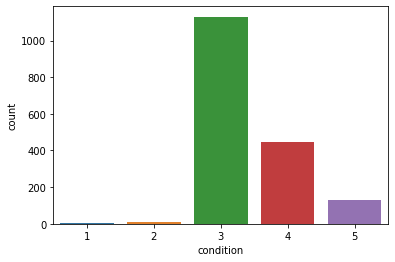

In [300]:
sns.countplot(x='condition', data=df)

<AxesSubplot:xlabel='grade', ylabel='count'>

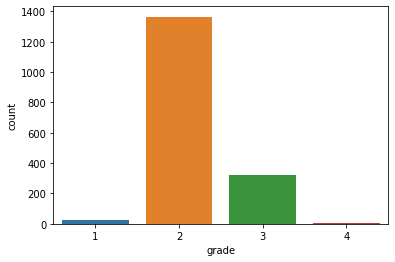

In [301]:
sns.countplot(x='grade', data=df)

In [ ]:
# sns.pairplot(df)

<AxesSubplot:xlabel='sqft_living', ylabel='sqft_above'>

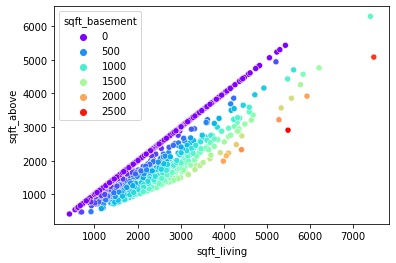

In [141]:
sns.scatterplot(y='sqft_above', x='sqft_living', data=df, hue='sqft_basement', palette='rainbow')

<AxesSubplot:xlabel='lat', ylabel='zipcode'>

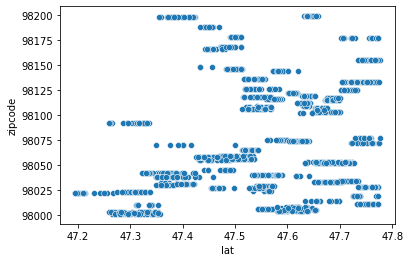

In [309]:
sns.scatterplot(y='zipcode', x='lat', data=df)

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

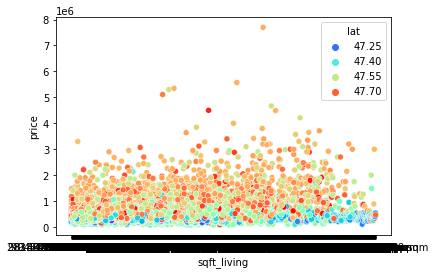

In [328]:
sns.scatterplot(y='price', x='sqft_living', data=full_df, hue='lat', palette='rainbow')

<AxesSubplot:xlabel='zipcode', ylabel='price'>

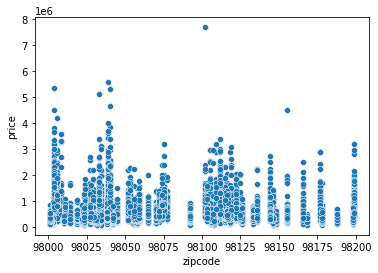

In [326]:
sns.scatterplot(y='price', x='zipcode', data=full_df)

<AxesSubplot:xlabel='zipcode', ylabel='Count'>

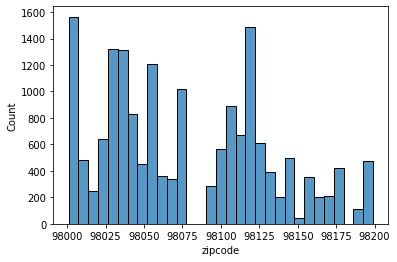

In [323]:
sns.histplot(x='zipcode', data=full_df)

hmm maybe we can add a new row that is number of houses in that zipcode

<AxesSubplot:xlabel='lat', ylabel='price'>

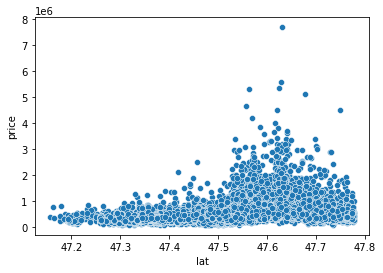

In [242]:
sns.scatterplot(y='price', x='lat', data=full_df)

<AxesSubplot:xlabel='lat', ylabel='Count'>

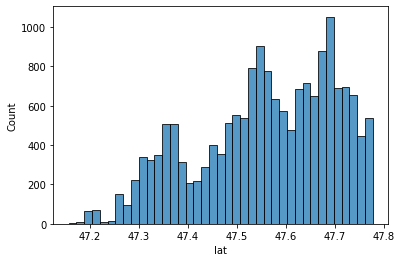

In [241]:
sns.histplot(x='lat', data=full_df)

<AxesSubplot:xlabel='long', ylabel='Count'>

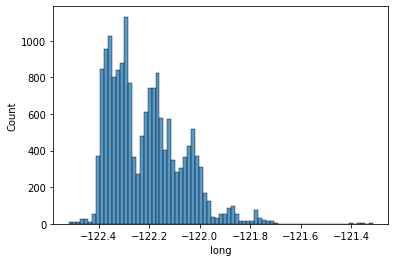

In [240]:
sns.histplot(x='long', data=full_df)

<AxesSubplot:xlabel='long', ylabel='price'>

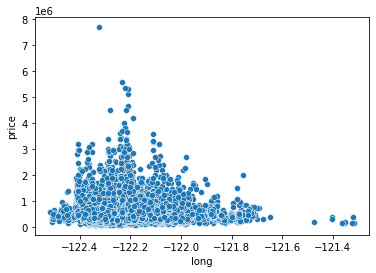

In [239]:
sns.scatterplot(y='price', x='long', data=full_df)

<AxesSubplot:xlabel='lat', ylabel='long'>

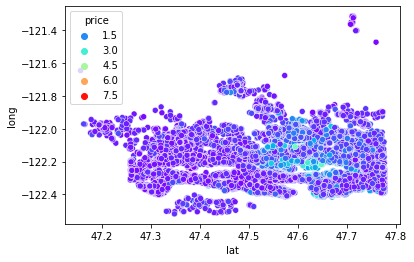

In [238]:
sns.scatterplot(y='long', x='lat', hue='price', data=full_df, palette='rainbow')

somewhere around (47.65, -122.22) seems to be the most expensive houses

<AxesSubplot:xlabel='yr_built', ylabel='price'>

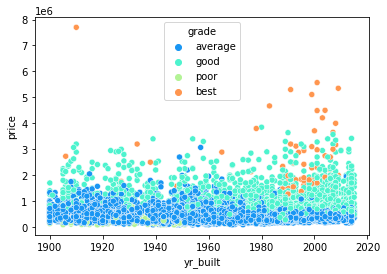

In [322]:
sns.scatterplot(y='price', x='yr_built', data=full_df, hue='grade', palette='rainbow')

### nice graphs (but after adding columns)

<AxesSubplot:xlabel='sq_sqft_living', ylabel='price'>

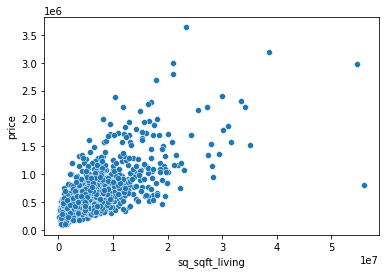

In [73]:
sns.scatterplot(y='price', x='sq_sqft_living', data=df)

<AxesSubplot:xlabel='bedrooms_per_floor', ylabel='Count'>

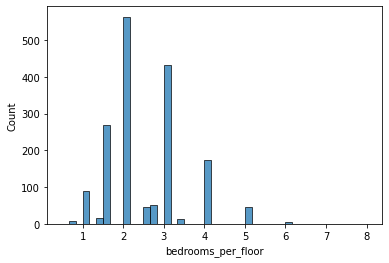

In [109]:
sns.histplot(x='bedrooms_per_floor', data=df)

<AxesSubplot:xlabel='bedrooms_per_floor', ylabel='price'>

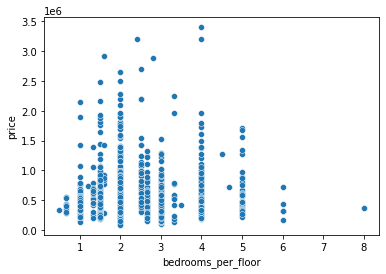

In [110]:
sns.scatterplot(y='price', x='bedrooms_per_floor', data=df)

<AxesSubplot:xlabel='house_density', ylabel='price'>

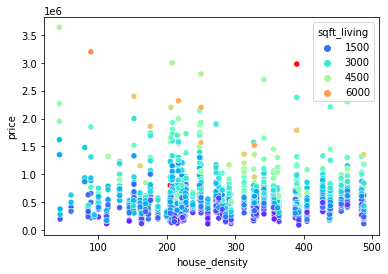

In [172]:
sns.scatterplot(y='price', x='house_density', data=df, hue='sqft_living', palette='rainbow')

<AxesSubplot:xlabel='distance', ylabel='price'>

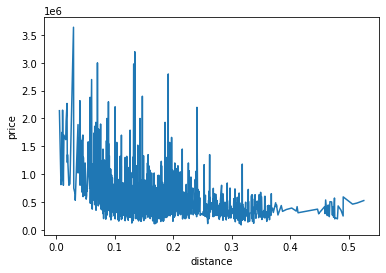

In [245]:
sns.lineplot(y='price', x='distance', data=df)

# feature selection

<AxesSubplot:>

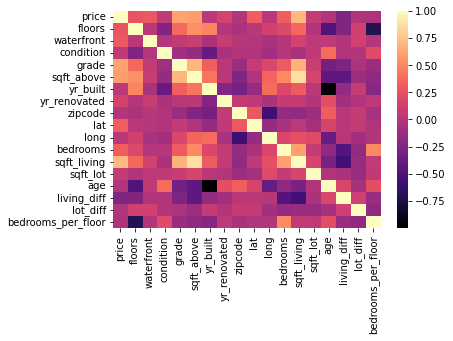

In [115]:
sns.heatmap(df.corr(), cmap='magma')

In [117]:
numeric_feature_cols = [x for x in df.columns if x not in ['price']]
#cat_feature_cols = []
target_col = ['price']

corrs = []
for col in numeric_feature_cols:
    corr = stats.spearmanr(df['price'], df[col])
    corrs.append({
        'feature': col,
        'correlation': corr[0],
        'p_value': corr[1]
    })

pd.DataFrame(corrs).sort_values('correlation')

,feature,correlation,p_value
14,living_diff,-0.287160,5.002096e-34
16,bedrooms_per_floor,-0.110698,4.162420e-06
13,age,-0.105631,1.127309e-05
15,lot_diff,-0.051370,3.309359e-02
2,condition,0.006636,7.832308e-01
7,zipcode,0.012661,5.996807e-01
12,sqft_lot,0.045170,6.100279e-02
9,long,0.053103,2.760121e-02
6,yr_renovated,0.089615,1.972962e-04
5,yr_built,0.106096,1.030669e-05


it seems like `price` correlates a lot with `id`, but that's just because of how the training dataset arranges the values, the `id` is just `price + some number`, in the testing dataset this is not the case, so we will drop it while training our model


so it seems like `date` doesn't have much of a relation with anything (the graphs just look like the histograms)

we can try to convert `date` into `age` (age of house in years)

## age
convert date sold to age

In [55]:
age = df.apply(lambda x: x['date'].year - x['yr_built'], axis=1)
age.name = 'age'
age

1409      37
12506     55
15008     12
2674     101
4314       9
        ... 
4414      27
14314     51
613      104
9323       9
7969       5
Name: age, Length: 1721, dtype: int64

In [56]:
df = df.drop(['id', 'date'], axis=1)
df = df.join(age)
df

,price,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,bedrooms,sqft_living,sqft_living15,sqft_lot,sqft_lot15,age
1409,686000.0,2.0,0,4,2,2130,0,1977,1869,98006,47.5567,-122.159,4.0,2130.000000,3380.000000,10650.000000,10050.000000,37
12506,595000.0,1.0,0,4,2,1350,0,1959,1869,98004,47.5807,-122.196,4.0,1350.000000,1930.000000,8113.000000,8113.000000,55
15008,350000.0,2.0,0,3,2,1000,210,2002,1869,98133,47.7114,-122.356,3.0,1210.000000,1650.000000,941.000000,1493.000000,12
2674,115000.0,1.0,0,3,1,1000,0,1913,1869,98001,47.2841,-122.255,2.0,1000.000000,1350.000000,16524.000000,10208.000000,101
4314,762500.0,2.0,0,3,3,3150,0,2005,1869,98052,47.7082,-122.101,4.0,3149.893876,3149.893876,5978.798567,6594.777814,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,434000.0,1.0,0,3,2,1210,540,1987,1869,98034,47.7305,-122.225,3.0,1750.000000,1930.000000,9353.000000,8545.000000,27
14314,300000.0,1.0,0,3,2,1260,630,1964,1869,98133,47.7740,-122.348,4.0,1890.000000,1430.000000,9205.000000,6775.000000,51
613,493000.0,1.0,0,3,2,1060,850,1910,1869,98122,47.6101,-122.295,4.0,1910.000000,1520.000000,2874.000000,2874.000000,104
9323,2200000.0,2.0,0,3,4,4570,1270,2006,1869,98029,47.5457,-121.991,5.0,5840.000000,4850.000000,17168.000000,15017.000000,9


## difference in square footage after renovation
then we replace the values after renovation with a relative difference

In [57]:
sqft_diffs = df.apply(lambda x: {
    'living_diff': (x['sqft_living15'] - x['sqft_living'])/x['sqft_living'],
    'lot_diff': (x['sqft_lot15'] - x['sqft_lot'])/x['sqft_lot']
}, axis=1, result_type='expand')

sqft_diffs

,living_diff,lot_diff
1409,0.586854,-0.056338
12506,0.429630,0.000000
15008,0.363636,0.586610
2674,0.350000,-0.382232
4314,0.000000,0.103027
...,...,...
4414,0.102857,-0.086389
14314,-0.243386,-0.263987
613,-0.204188,0.000000
9323,-0.169521,-0.125291


In [58]:
df = df.drop(['sqft_living15', 'sqft_lot15'], axis=1)
df = df.join(sqft_diffs)

df

,price,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,bedrooms,sqft_living,sqft_lot,age,living_diff,lot_diff
1409,686000.0,2.0,0,4,2,2130,0,1977,1869,98006,47.5567,-122.159,4.0,2130.000000,10650.000000,37,0.586854,-0.056338
12506,595000.0,1.0,0,4,2,1350,0,1959,1869,98004,47.5807,-122.196,4.0,1350.000000,8113.000000,55,0.429630,0.000000
15008,350000.0,2.0,0,3,2,1000,210,2002,1869,98133,47.7114,-122.356,3.0,1210.000000,941.000000,12,0.363636,0.586610
2674,115000.0,1.0,0,3,1,1000,0,1913,1869,98001,47.2841,-122.255,2.0,1000.000000,16524.000000,101,0.350000,-0.382232
4314,762500.0,2.0,0,3,3,3150,0,2005,1869,98052,47.7082,-122.101,4.0,3149.893876,5978.798567,9,0.000000,0.103027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,434000.0,1.0,0,3,2,1210,540,1987,1869,98034,47.7305,-122.225,3.0,1750.000000,9353.000000,27,0.102857,-0.086389
14314,300000.0,1.0,0,3,2,1260,630,1964,1869,98133,47.7740,-122.348,4.0,1890.000000,9205.000000,51,-0.243386,-0.263987
613,493000.0,1.0,0,3,2,1060,850,1910,1869,98122,47.6101,-122.295,4.0,1910.000000,2874.000000,104,-0.204188,0.000000
9323,2200000.0,2.0,0,3,4,4570,1270,2006,1869,98029,47.5457,-121.991,5.0,5840.000000,17168.000000,9,-0.169521,-0.125291


## bedrooms per floor

In [59]:
beds_per_floor = df.apply(lambda x: x['bedrooms']/x['floors'], axis=1)
beds_per_floor.name = 'bedrooms_per_floor'
beds_per_floor

1409     2.0
12506    4.0
15008    1.5
2674     2.0
4314     2.0
        ... 
4414     3.0
14314    4.0
613      4.0
9323     2.5
7969     1.5
Name: bedrooms_per_floor, Length: 1721, dtype: float64

In [60]:
df = df.join(beds_per_floor)
df

,price,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,bedrooms,sqft_living,sqft_lot,age,living_diff,lot_diff,bedrooms_per_floor
1409,686000.0,2.0,0,4,2,2130,0,1977,1869,98006,47.5567,-122.159,4.0,2130.000000,10650.000000,37,0.586854,-0.056338,2.0
12506,595000.0,1.0,0,4,2,1350,0,1959,1869,98004,47.5807,-122.196,4.0,1350.000000,8113.000000,55,0.429630,0.000000,4.0
15008,350000.0,2.0,0,3,2,1000,210,2002,1869,98133,47.7114,-122.356,3.0,1210.000000,941.000000,12,0.363636,0.586610,1.5
2674,115000.0,1.0,0,3,1,1000,0,1913,1869,98001,47.2841,-122.255,2.0,1000.000000,16524.000000,101,0.350000,-0.382232,2.0
4314,762500.0,2.0,0,3,3,3150,0,2005,1869,98052,47.7082,-122.101,4.0,3149.893876,5978.798567,9,0.000000,0.103027,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,434000.0,1.0,0,3,2,1210,540,1987,1869,98034,47.7305,-122.225,3.0,1750.000000,9353.000000,27,0.102857,-0.086389,3.0
14314,300000.0,1.0,0,3,2,1260,630,1964,1869,98133,47.7740,-122.348,4.0,1890.000000,9205.000000,51,-0.243386,-0.263987,4.0
613,493000.0,1.0,0,3,2,1060,850,1910,1869,98122,47.6101,-122.295,4.0,1910.000000,2874.000000,104,-0.204188,0.000000,4.0
9323,2200000.0,2.0,0,3,4,4570,1270,2006,1869,98029,47.5457,-121.991,5.0,5840.000000,17168.000000,9,-0.169521,-0.125291,2.5


## zipcode houses

number of houses sold in total in that zipcode

In [62]:
value_counts = full_df['zipcode'].value_counts()
house_density = df.apply(lambda x: value_counts[x['zipcode']], axis=1)
house_density.name = 'house_density'
df = df.join(house_density)

df

,price,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,bedrooms,sqft_living,sqft_lot,age,living_diff,lot_diff,bedrooms_per_floor,house_density
1409,686000.0,2.0,0,4,2,2130,0,1977,1869,98006,47.5567,-122.159,4.0,2130.000000,10650.000000,37,0.586854,-0.056338,2.0,390
12506,595000.0,1.0,0,4,2,1350,0,1959,1869,98004,47.5807,-122.196,4.0,1350.000000,8113.000000,55,0.429630,0.000000,4.0,248
15008,350000.0,2.0,0,3,2,1000,210,2002,1869,98133,47.7114,-122.356,3.0,1210.000000,941.000000,12,0.363636,0.586610,1.5,388
2674,115000.0,1.0,0,3,1,1000,0,1913,1869,98001,47.2841,-122.255,2.0,1000.000000,16524.000000,101,0.350000,-0.382232,2.0,294
4314,762500.0,2.0,0,3,3,3150,0,2005,1869,98052,47.7082,-122.101,4.0,3149.893876,5978.798567,9,0.000000,0.103027,2.0,455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,434000.0,1.0,0,3,2,1210,540,1987,1869,98034,47.7305,-122.225,3.0,1750.000000,9353.000000,27,0.102857,-0.086389,3.0,439
14314,300000.0,1.0,0,3,2,1260,630,1964,1869,98133,47.7740,-122.348,4.0,1890.000000,9205.000000,51,-0.243386,-0.263987,4.0,388
613,493000.0,1.0,0,3,2,1060,850,1910,1869,98122,47.6101,-122.295,4.0,1910.000000,2874.000000,104,-0.204188,0.000000,4.0,228
9323,2200000.0,2.0,0,3,4,4570,1270,2006,1869,98029,47.5457,-121.991,5.0,5840.000000,17168.000000,9,-0.169521,-0.125291,2.5,250


## square sqft_living

In [71]:
sq_sqft_living = df.apply(lambda x: pow(x['sqft_living'], 2), axis=1)
sq_sqft_living.name = 'sq_sqft_living'
df = df.join(sq_sqft_living)

df

,price,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,...,sqft_living,sqft_lot,age,living_diff,lot_diff,bedrooms_per_floor,house_density,sqrt_sqft_living,log_sqft_living,sq_sqft_living
1409,686000.0,2.0,0,4,2,2130,0,1977,1869,98006,...,2130.000000,10650.000000,37,0.586854,-0.056338,2.0,390,46.151923,7.663877,4.536900e+06
12506,595000.0,1.0,0,4,2,1350,0,1959,1869,98004,...,1350.000000,8113.000000,55,0.429630,0.000000,4.0,248,36.742346,7.207860,1.822500e+06
15008,350000.0,2.0,0,3,2,1000,210,2002,1869,98133,...,1210.000000,941.000000,12,0.363636,0.586610,1.5,388,34.785054,7.098376,1.464100e+06
2674,115000.0,1.0,0,3,1,1000,0,1913,1869,98001,...,1000.000000,16524.000000,101,0.350000,-0.382232,2.0,294,31.622777,6.907755,1.000000e+06
4314,762500.0,2.0,0,3,3,3150,0,2005,1869,98052,...,3149.893876,5978.798567,9,0.000000,0.103027,2.0,455,56.123915,8.055124,9.921831e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,434000.0,1.0,0,3,2,1210,540,1987,1869,98034,...,1750.000000,9353.000000,27,0.102857,-0.086389,3.0,439,41.833001,7.467371,3.062500e+06
14314,300000.0,1.0,0,3,2,1260,630,1964,1869,98133,...,1890.000000,9205.000000,51,-0.243386,-0.263987,4.0,388,43.474130,7.544332,3.572100e+06
613,493000.0,1.0,0,3,2,1060,850,1910,1869,98122,...,1910.000000,2874.000000,104,-0.204188,0.000000,4.0,228,43.703547,7.554859,3.648100e+06
9323,2200000.0,2.0,0,3,4,4570,1270,2006,1869,98029,...,5840.000000,17168.000000,9,-0.169521,-0.125291,2.5,250,76.419893,8.672486,3.410560e+07


## distance from center

In [243]:
lat_center = 47.62
long_center = -122.22

distance = df.apply(lambda x: np.sqrt((x['lat'] - lat_center) ** 2 + (x['long'] - long_center) ** 2), axis=1)
distance.name = 'distance'
df = df.join(distance)

df

,price,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,...,bedrooms,sqft_living,sqft_lot,age,living_diff,lot_diff,bedrooms_per_floor,house_density,sq_sqft_living,distance
1409,686000.0,2.0,0,4,2,2130,0,1977,1869,98006,...,4.0,2130.000000,10650.000000,37,0.586854,-0.056338,2.0,390,4.536900e+06,0.087908
12506,595000.0,1.0,0,4,2,1350,0,1959,1869,98004,...,4.0,1350.000000,8113.000000,55,0.429630,0.000000,4.0,248,1.822500e+06,0.046049
15008,350000.0,2.0,0,3,2,1000,210,2002,1869,98133,...,3.0,1210.000000,941.000000,12,0.363636,0.586610,1.5,388,1.464100e+06,0.163860
2674,115000.0,1.0,0,3,1,1000,0,1913,1869,98001,...,2.0,1000.000000,16524.000000,101,0.350000,-0.382232,2.0,294,1.000000e+06,0.337719
4314,762500.0,2.0,0,3,3,3150,0,2005,1869,98052,...,4.0,3149.893876,5978.798567,9,0.000000,0.103027,2.0,455,9.921831e+06,0.148122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,434000.0,1.0,0,3,2,1210,540,1987,1869,98034,...,3.0,1750.000000,9353.000000,27,0.102857,-0.086389,3.0,439,3.062500e+06,0.110613
14314,300000.0,1.0,0,3,2,1260,630,1964,1869,98133,...,4.0,1890.000000,9205.000000,51,-0.243386,-0.263987,4.0,388,3.572100e+06,0.200250
613,493000.0,1.0,0,3,2,1060,850,1910,1869,98122,...,4.0,1910.000000,2874.000000,104,-0.204188,0.000000,4.0,228,3.648100e+06,0.075651
9323,2200000.0,2.0,0,3,4,4570,1270,2006,1869,98029,...,5.0,5840.000000,17168.000000,9,-0.169521,-0.125291,2.5,250,3.410560e+07,0.240752


# running algos

ok now comes the part where we actually run models, first we need to split our training data into 2 - one of them is for our model to learn with, the other will be to test our model

we need 2 of these, because we need to test the model with data it hasn't seen before, to get a more accurate assessment

In [77]:
df

,price,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,...,long,bedrooms,sqft_living,sqft_lot,age,living_diff,lot_diff,bedrooms_per_floor,house_density,sq_sqft_living
1409,686000.0,2.0,0,4,2,2130,0,1977,1869,98006,...,-122.159,4.0,2130.000000,10650.000000,37,0.586854,-0.056338,2.0,390,4.536900e+06
12506,595000.0,1.0,0,4,2,1350,0,1959,1869,98004,...,-122.196,4.0,1350.000000,8113.000000,55,0.429630,0.000000,4.0,248,1.822500e+06
15008,350000.0,2.0,0,3,2,1000,210,2002,1869,98133,...,-122.356,3.0,1210.000000,941.000000,12,0.363636,0.586610,1.5,388,1.464100e+06
2674,115000.0,1.0,0,3,1,1000,0,1913,1869,98001,...,-122.255,2.0,1000.000000,16524.000000,101,0.350000,-0.382232,2.0,294,1.000000e+06
4314,762500.0,2.0,0,3,3,3150,0,2005,1869,98052,...,-122.101,4.0,3149.893876,5978.798567,9,0.000000,0.103027,2.0,455,9.921831e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4414,434000.0,1.0,0,3,2,1210,540,1987,1869,98034,...,-122.225,3.0,1750.000000,9353.000000,27,0.102857,-0.086389,3.0,439,3.062500e+06
14314,300000.0,1.0,0,3,2,1260,630,1964,1869,98133,...,-122.348,4.0,1890.000000,9205.000000,51,-0.243386,-0.263987,4.0,388,3.572100e+06
613,493000.0,1.0,0,3,2,1060,850,1910,1869,98122,...,-122.295,4.0,1910.000000,2874.000000,104,-0.204188,0.000000,4.0,228,3.648100e+06
9323,2200000.0,2.0,0,3,4,4570,1270,2006,1869,98029,...,-121.991,5.0,5840.000000,17168.000000,9,-0.169521,-0.125291,2.5,250,3.410560e+07


## split data

In [182]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape

((1290, 20), (431, 20))

## seeing scores

we can run various different regression models, then see the scores they give us when run without any additional configuration

In [79]:
lr = LinearRegression()

lr1 = lr.fit(X_train, y_train)
lr1.score(X_test, y_test)

0.5739150520796705

In [20]:
ada = AdaBoostRegressor(random_state=1, n_estimators=7) # seems to overfit unless n_estimators is really small

ada1 = ada.fit(X_train, y_train)
ada1.score(X_test, y_test)

0.6221580675303136

In [185]:
gbr = GradientBoostingRegressor(random_state=1)

gbr1 = gbr.fit(X_train, y_train)
gbr1.score(X_test, y_test)

0.7762092065510047

In [184]:
hgbr = HistGradientBoostingRegressor(random_state=1)

hgbr1 = gbr.fit(X_train, y_train)
hgbr1.score(X_test, y_test)

0.7762092065510047

In [80]:
xgb = XGBRegressor(random_state=1)

xgb1 = xgb.fit(X_train, y_train)
xgb1.score(X_test, y_test)

0.7600073509084386

In [85]:
dtr = DecisionTreeRegressor(random_state=1)

dtr1 = dtr.fit(X_train, y_train)
dtr1.score(X_test, y_test)

0.6049223636853619

In [183]:
rfr = RandomForestRegressor(random_state=1)

rfr1 = rfr.fit(X_train, y_train)
rfr1.score(X_test, y_test)

0.731167148942863

In [83]:
cbr = CatBoostRegressor(random_state=1, verbose=0)

cbr1 = cbr.fit(X_train, y_train)
cbr1.score(X_test, y_test)

0.8224347545735248

In [84]:
lgbm = LGBMRegressor(random_state=1)

lgbm1 = lgbm.fit(X_train, y_train)
lgbm1.score(X_test, y_test)

0.7274424819978319

## graphing outputs

by plotting this we can get more of a grasp on where the errors are coming from in the predictions for each of our models, see if we are overfitting

In [27]:
lr_pred = lr1.predict(X_test)
ada_pred = ada1.predict(X_test)
gbr_pred = gbr1.predict(X_test)
xgb_pred = xgb1.predict(X_test)
dtr_pred = dtr1.predict(X_test)
rfr_pred = rfr1.predict(X_test)
cbr_pred = cbr1.predict(X_test)
lgbm_pred = lgbm1.predict(X_test)

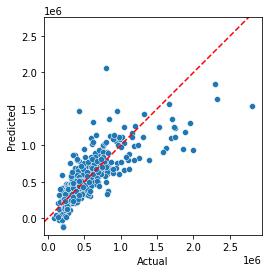

In [28]:
# linear regression

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': lr_pred})

max_price = y_test.max()
sns.scatterplot(x='Actual', y='Predicted', data=df_results)
plt.axis('square')
plt.axline((0, 0), (max_price, max_price), color='red', linestyle='--')
plt.show()

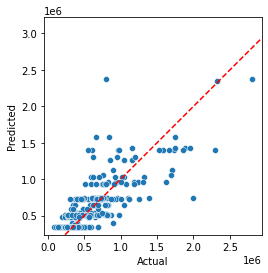

In [29]:
# adaboost

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': ada_pred})

max_price = y_test.max()
sns.scatterplot(x='Actual', y='Predicted', data=df_results)
plt.axis('square')
plt.axline((0, 0), (max_price, max_price), color='red', linestyle='--')
plt.show()

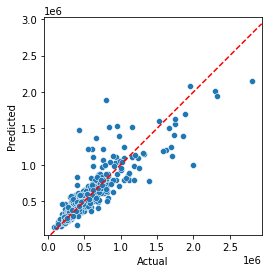

In [30]:
# scikitlearn gradient boost

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': gbr_pred})

max_price = y_test.max()
sns.scatterplot(x='Actual', y='Predicted', data=df_results)
plt.axis('square')
plt.axline((0, 0), (max_price, max_price), color='red', linestyle='--')
plt.show()

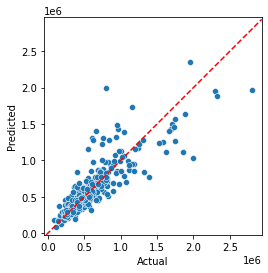

In [31]:
# xgboost

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': xgb_pred})

max_price = y_test.max()
sns.scatterplot(x='Actual', y='Predicted', data=df_results)
plt.axis('square')
plt.axline((0, 0), (max_price, max_price), color='red', linestyle='--')
plt.show()

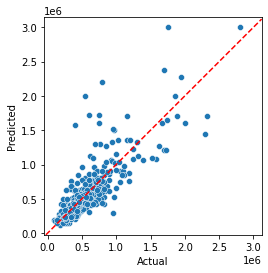

In [32]:
# decision tree

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': dtr_pred})

max_price = y_test.max()
sns.scatterplot(x='Actual', y='Predicted', data=df_results)
plt.axis('square')
plt.axline((0, 0), (max_price, max_price), color='red', linestyle='--')
plt.show()

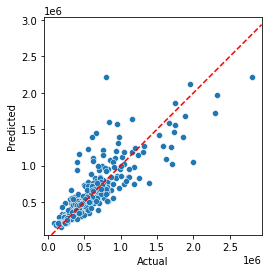

In [33]:
# random forest

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': rfr_pred})

max_price = y_test.max()
sns.scatterplot(x='Actual', y='Predicted', data=df_results)
plt.axis('square')
plt.axline((0, 0), (max_price, max_price), color='red', linestyle='--')
plt.show()

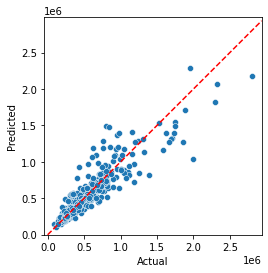

In [34]:
# cat boost

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': cbr_pred})

max_price = y_test.max()
sns.scatterplot(x='Actual', y='Predicted', data=df_results)
plt.axis('square')
plt.axline((0, 0), (max_price, max_price), color='red', linestyle='--')
plt.show()

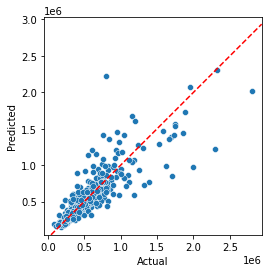

In [35]:
# lgbm

df_results = pd.DataFrame({'Actual': y_test, 'Predicted': lgbm_pred})

max_price = y_test.max()
sns.scatterplot(x='Actual', y='Predicted', data=df_results)
plt.axis('square')
plt.axline((0, 0), (max_price, max_price), color='red', linestyle='--')
plt.show()

## parameter tuning

### useful functions

In [454]:
# all the preprocessing but in one function
def preprocess(df):
    for col in ['bedrooms', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']:
        df = fix_unit(col, df)

    date = pd.to_datetime(df['date'], infer_datetime_format=True)
    df = df.drop(['date'], axis=1)
    df = df.join(date)

    replacement = {
        "condition": {
            "very poor": 1,
            "poor": 2,
            "average": 3,
            "good": 4,
            "very good": 5
        },

        "grade": {
            "poor": 1,
            "average": 2,
            "good": 3,
            "best": 4
        }
    }

    df = df.replace(replacement)

    age = df.apply(lambda x: x['date'].year - x['yr_built'], axis=1)
    age.name = 'age'
    df = df.drop(['id', 'date'], axis=1)
    df = df.join(age)

    sqft_diffs = df.apply(lambda x: {
        'living_diff': (x['sqft_living15'] - x['sqft_living'])/x['sqft_living'],
        'lot_diff': (x['sqft_lot15'] - x['sqft_lot'])/x['sqft_lot']
    }, axis=1, result_type='expand')
    df = df.drop(['sqft_living15', 'sqft_lot15'], axis=1)
    df = df.join(sqft_diffs)

    beds_per_floor = df.apply(lambda x: x['bedrooms']/x['floors'], axis=1)
    beds_per_floor.name = 'bedrooms_per_floor'
    df = df.join(beds_per_floor)
    
    value_counts = full_df['zipcode'].value_counts()
    house_density = df.apply(lambda x: value_counts[x['zipcode']], axis=1)
    house_density.name = 'house_density'
    df = df.join(house_density)
    
    sq_sqft_living = df.apply(lambda x: pow(x['sqft_living'], 2), axis=1)
    sq_sqft_living.name = 'sq_sqft_living'
    df = df.join(sq_sqft_living)
    
    lat_center = 47.62
    long_center = -122.22

    distance = df.apply(lambda x: np.sqrt((x['lat'] - lat_center) ** 2 + (x['long'] - long_center) ** 2), axis=1)
    distance.name = 'distance'
    df = df.join(distance)

#     df = df.drop(['age'], axis=1)

#     df = df.drop(['sqft_basement'], axis=1)

#     df = df.drop(['zipcode'], axis=1)
    
    return df

In [455]:
df = preprocess(full_df.sample(frac=0.1, random_state=2))
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)
X_train.shape, X_test.shape

((1290, 21), (431, 21))

### now run

In [502]:
reg = CatBoostRegressor()

parameters = {
    'iterations': [None, 100, 200, 400],
    'learning_rate': [0.05, 0.1, 0.2, 1],
    'depth': [5, 6, 7, 8, 9, 10],
    'verbose': [0],
    'l2_leaf_reg': [0.5, 1, 3, 10],
    'colsample_bylevel': [0.1, 0.24, 0.5, 1]
}

reg_grid = GridSearchCV(
    reg,
    parameters,
    cv=5,
    n_jobs=7,
    scoring='neg_mean_squared_error',
    verbose=1
)

print("started at", datetime.datetime.now())
reg_grid.fit(X, y)
print("finished at", datetime.datetime.now())

print(reg_grid.best_score_)
for param in reg_grid.best_params_:
    print("%s=%s" % (param, reg_grid.best_params_[param]), end=", ")

started at 2022-02-15 21:31:14.381980
Fitting 5 folds for each of 1536 candidates, totalling 7680 fits


KeyboardInterrupt: 

CatBoost has its own tools so trying those

In [500]:
cbr = CatBoostRegressor(colsample_bylevel=0.24, learning_rate=0.1, max_depth=5, random_state=1, verbose=0)
cbr1 = cbr.fit(X_train, y_train, eval_set=Pool(X_test, y_test))
cbr1.get_best_iteration()

448

In [501]:
# 82-88
best = CatBoostRegressor(colsample_bylevel=0.24, learning_rate=0.1, max_depth=5, random_state=1, verbose=0)

# 76-86
# best = LGBMRegressor(learning_rate=0.1, max_depth=6, min_data_in_leaf=10, num_leaves=20, random_state=0, verbose=-1)

# 75-85
# best = HistGradientBoostingRegressor(learning_rate=0.07, max_depth=5, max_iter=170, max_leaf_nodes=25, min_samples_leaf=10, random_state=0)

# 79-85
# best = RandomForestRegressor(max_depth=11, max_features='auto', min_samples_leaf=1, min_samples_split=3, n_estimators=40)

In [494]:
scores = cross_validate(best, X, y, cv=KFold(n_splits=5))['test_score']

mean = np.mean(scores)
sum_dev = 0
for score in scores:
    sum_dev += abs(score - mean)

print(scores)
print(round(mean * 100, 1), "+/-", round(sum_dev * 100/len(scores), 1))

[0.80332684 0.87030444 0.89121727 0.8499461  0.80345853]
84.4 +/- 3.2


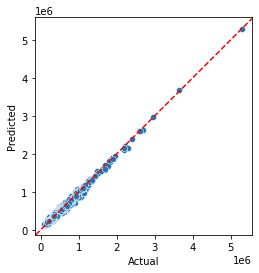

In [495]:
best1 = best.fit(X_train, y_train)
prediction = best1.predict(X_train)
df_results = pd.DataFrame({'Actual': y_train, 'Predicted': prediction})

max_price = y_train.max()
sns.scatterplot(x='Actual', y='Predicted', data=df_results)
plt.axis('square')
plt.axline((0, 0), (max_price, max_price), color='red', linestyle='--')
plt.show()

In [496]:
for i in range(0, len(X_train.columns)):
    print("%s%f" % (X_train.columns[i].ljust(20, ' '), best1.feature_importances_[i]))

floors              1.002503
waterfront          8.861880
condition           0.515954
grade               13.168088
sqft_above          6.491320
sqft_basement       1.956886
yr_built            2.659076
yr_renovated        0.370326
zipcode             2.716415
lat                 14.602116
long                3.427546
bedrooms            0.996701
sqft_living         10.278088
sqft_lot            1.464413
age                 1.192429
living_diff         3.096304
lot_diff            1.189996
bedrooms_per_floor  0.715888
house_density       3.245806
sq_sqft_living      12.616931
distance            9.431333


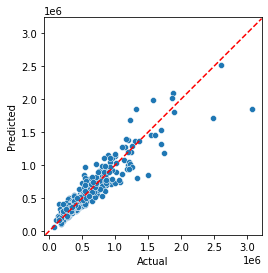

In [497]:
prediction = best1.predict(X_test)
df_results = pd.DataFrame({'Actual': y_test, 'Predicted': prediction})

max_price = y_test.max()
sns.scatterplot(x='Actual', y='Predicted', data=df_results)
plt.axis('square')
plt.axline((0, 0), (max_price, max_price), color='red', linestyle='--')
plt.show()

# submission

make sure we train our best model on the *whole* dataset (making this mistake only 2 times)

In [444]:
df = preprocess(full_df)

# then we run the fixing code

In [445]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17210 entries, 0 to 17209
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               17210 non-null  float64
 1   floors              17210 non-null  float64
 2   waterfront          17210 non-null  int64  
 3   condition           17210 non-null  int64  
 4   grade               17210 non-null  int64  
 5   sqft_above          17210 non-null  int64  
 6   sqft_basement       17210 non-null  int64  
 7   yr_built            17210 non-null  int64  
 8   yr_renovated        17210 non-null  int64  
 9   zipcode             17210 non-null  int64  
 10  lat                 17210 non-null  float64
 11  long                17210 non-null  float64
 12  bedrooms            17210 non-null  float64
 13  sqft_living         17210 non-null  float64
 14  sqft_lot            17210 non-null  float64
 15  age                 17210 non-null  int64  
 16  livi

In [446]:
X_train = df.drop(['price'], axis=1)
y_train = df['price']

best = CatBoostRegressor(depth=5, iterations=300, l2_leaf_reg=0.5, learning_rate=0.05, verbose=0)

best1 = best.fit(X_train, y_train)

In [447]:
df = pd.read_csv('test.csv')

# before we do any processing, make sure to keep the "id"s safe
ids = df['id'].to_numpy()

df = preprocess(df)

df

,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,bedrooms,sqft_living,sqft_lot,age,living_diff,lot_diff,bedrooms_per_floor,house_density,sq_sqft_living
0,2.0,0,3,2,1715,0,1995,1869,98003,47.3097,-122.327,3.0,1715.0,6819.0,19,0.304956,0.000000,1.5,225,2941225.0
1,2.0,0,3,2,1890,0,2003,1869,98038,47.3684,-122.031,3.0,1890.0,6560.0,12,0.264550,0.153963,1.5,488,3572100.0
2,2.0,0,3,3,1980,970,1979,1869,98126,47.5714,-122.375,4.0,2950.0,5000.0,36,-0.274576,-0.200000,2.0,281,8702500.0
3,1.0,0,4,2,1200,0,1921,1869,98002,47.3089,-122.210,2.0,1200.0,9850.0,93,-0.116667,-0.482741,2.0,163,1440000.0
4,1.0,0,4,2,860,760,1947,1869,98133,47.7025,-122.341,4.0,1620.0,4980.0,67,-0.135802,0.000000,4.0,388,2624400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205,3.0,0,3,2,1680,0,2014,1869,98103,47.6572,-122.346,3.0,1680.0,1570.0,0,-0.023810,2.057325,1.0,485,2822400.0
4206,2.0,0,3,3,1250,650,2014,1869,98144,47.5869,-122.311,4.0,1900.0,2631.0,1,-0.100000,0.711136,2.0,272,3610000.0
4207,2.0,0,3,3,2780,0,2013,1869,98065,47.5184,-121.886,3.0,2780.0,6000.0,1,0.025180,0.000000,1.5,238,7728400.0
4208,2.0,0,3,2,1020,190,2007,1869,98117,47.6756,-122.375,2.0,1210.0,1278.0,7,0.000000,-0.125196,1.0,428,1464100.0


In [448]:
df

,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,bedrooms,sqft_living,sqft_lot,age,living_diff,lot_diff,bedrooms_per_floor,house_density,sq_sqft_living
0,2.0,0,3,2,1715,0,1995,1869,98003,47.3097,-122.327,3.0,1715.0,6819.0,19,0.304956,0.000000,1.5,225,2941225.0
1,2.0,0,3,2,1890,0,2003,1869,98038,47.3684,-122.031,3.0,1890.0,6560.0,12,0.264550,0.153963,1.5,488,3572100.0
2,2.0,0,3,3,1980,970,1979,1869,98126,47.5714,-122.375,4.0,2950.0,5000.0,36,-0.274576,-0.200000,2.0,281,8702500.0
3,1.0,0,4,2,1200,0,1921,1869,98002,47.3089,-122.210,2.0,1200.0,9850.0,93,-0.116667,-0.482741,2.0,163,1440000.0
4,1.0,0,4,2,860,760,1947,1869,98133,47.7025,-122.341,4.0,1620.0,4980.0,67,-0.135802,0.000000,4.0,388,2624400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4205,3.0,0,3,2,1680,0,2014,1869,98103,47.6572,-122.346,3.0,1680.0,1570.0,0,-0.023810,2.057325,1.0,485,2822400.0
4206,2.0,0,3,3,1250,650,2014,1869,98144,47.5869,-122.311,4.0,1900.0,2631.0,1,-0.100000,0.711136,2.0,272,3610000.0
4207,2.0,0,3,3,2780,0,2013,1869,98065,47.5184,-121.886,3.0,2780.0,6000.0,1,0.025180,0.000000,1.5,238,7728400.0
4208,2.0,0,3,2,1020,190,2007,1869,98117,47.6756,-122.375,2.0,1210.0,1278.0,7,0.000000,-0.125196,1.0,428,1464100.0


after that, we can run our best model on it

In [449]:
test_pred = best1.predict(df)

test_pred

array([265559.20271812, 318925.32803343, 949962.46185728, ...,
       577372.39731912, 431921.89855012, 435094.06164491])

In [450]:
df_submission = pd.DataFrame(test_pred, columns=['price'])
df_submission

,price
0,265559.202718
1,318925.328033
2,949962.461857
3,183592.077546
4,450359.112865
...,...
4205,570611.759747
4206,649465.988728
4207,577372.397319
4208,431921.898550


In [451]:
df_ids = pd.DataFrame(ids, columns=['id'], index=None)
df_ids

,id
0,1321400060
1,3793500160
2,9297300055
3,16000397
4,6300500875
...,...
4205,1931300090
4206,3881900317
4207,7853420110
4208,2767600688


In [452]:
result = df_ids.join(df_submission)
result

,id,price
0,1321400060,265559.202718
1,3793500160,318925.328033
2,9297300055,949962.461857
3,16000397,183592.077546
4,6300500875,450359.112865
...,...,...
4205,1931300090,570611.759747
4206,3881900317,649465.988728
4207,7853420110,577372.397319
4208,2767600688,431921.898550


In [453]:
result.to_csv('test_prediction_8.csv', index=False)